In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import os
from pathlib import Path
import logging
import random
import itertools
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from sentiment_analysis.config import SentimentAnalysisConfig
from sentiment_analysis.data_access import DataClass
from sentiment_analysis.features import Features
from sentiment_analysis.evaluation import CustomEvaluation
from sentiment_analysis.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    TRAIN,
    VALID,
    TEST,
    SAVED_MODELS,
    PREDICTION
)

device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 128
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [3]:
config = SentimentAnalysisConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(10)

2022-12-05 02:26:56,067 - sentiment_analysis.utils.utils - INFO - func:build took: 1.27 sec


,review,sentiment,Split
0,how can a director that makes such great films...,neg,development
1,This is one of the worst film adaptations of a...,neg,development
2,This is an art film that was either made in 19...,neg,development
3,"For two of the funniest comedians, the movie w...",neg,development
4,Doris Day never lets a bad script get her down...,neg,development
5,Unwatchable. You can't even make it past the f...,neg,development
6,"Quite average even by Monogram standards, this...",neg,development
7,This is not a good movie. Too preachy in parts...,neg,development
8,I am really shocked that a great director like...,neg,development
9,This is one of the weakest soft porn film arou...,neg,development


In [4]:
features = Features()
df_features = features.build(df)

2022-12-05 02:28:13,533 - sentiment_analysis.utils.utils - INFO - func:clean took: 1 min and                 17.29 sec
2022-12-05 02:28:31,797 - sentiment_analysis.utils.utils - INFO - func:fit took: 18.24 sec
2022-12-05 02:28:48,026 - sentiment_analysis.utils.utils - INFO - func:transform took: 16.23 sec
2022-12-05 02:28:48,027 - sentiment_analysis.utils.utils - INFO - func:fit_transform took: 34.47 sec
2022-12-05 02:28:49,687 - sentiment_analysis.utils.utils - INFO - func:transform took: 1.66 sec
2022-12-05 02:29:07,209 - sentiment_analysis.utils.utils - INFO - func:transform took: 17.52 sec
2022-12-05 02:29:08,927 - sentiment_analysis.utils.utils - INFO - func:build took: 2 min and                 12.69 sec


In [5]:
df_features.head(3)

,review,sentiment,Split,Original Text,char__ 00,char__ 1,char__ 10,char__ 11,char__ 12,char__ 13,...,word__york city,word__youll see,word__young boy,word__young girl,word__young man,word__young woman,word__youre going,word__youre looking,word__youve got,word__youve seen
0,saw movie tv afternoon cant see anyone sit pie...,0,train,I saw this movie on t.v. this afternoon and I ...,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,film true historical film useful researching l...,1,train,This film is a true and historical film. It is...,0.0,0.0,0.05085,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,film something like sequel white zombie since ...,0,train,"This film is something like a sequel of ""White...",0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prepare data for training and validation

In [6]:
train = df_features[df_features[SPLIT].isin([TRAIN])].copy()
valid = df_features[df_features[SPLIT].isin([VALID])].copy()
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

X_train = train[features.vectorizer.get_feature_names_out()].copy()
X_valid = valid[features.vectorizer.get_feature_names_out()].copy()
Y_train = train[TARGET]
Y_valid = valid[TARGET]

pos_prob_train = sum(Y_train) / len(Y_train)
pos_prob_valid = sum(Y_train) / len(Y_train)
print(f"Number of features: {X_train.shape[1]:,}")
print(f"Number of training samples: {X_train.shape[0]:,}")
print(f"Training set label distribution: pos:{pos_prob_train:0.2f}, neg:{1-pos_prob_train:0.2f}")
print(f"Number of validation samples: {X_valid.shape[0]:,}")
print(f"Validation set label distribution: pos:{pos_prob_valid:0.2f}, neg:{1-pos_prob_valid:0.2f}")

Number of features: 5,000
Number of training samples: 22,500
Training set label distribution: pos:0.50, neg:0.50
Number of validation samples: 2,500
Validation set label distribution: pos:0.50, neg:0.50


Define custom dataset

In [7]:
class CustomDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        model_name: str,
        max_length: int = 128
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        row = self.data.iloc[index]
        text = row[ORIGINAL_TEXT]
        target = np.array(row[TARGET]).reshape(-1,)
        inputs = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt'
        )

        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "token_type_ids": inputs["token_type_ids"].flatten(),
            "target": torch.FloatTensor(target)
        }


Define the pre-trained model with classifier head

In [8]:
class Model(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(self.l1.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.l1(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        out = self.l2(out.pooler_output)
        out = self.l3(out)
        return out

Choose model and load the tokenizer

In [9]:
MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Token-length analysis based on tokenizer

This is important in deciding `MAX_TOKEN_COUNT`

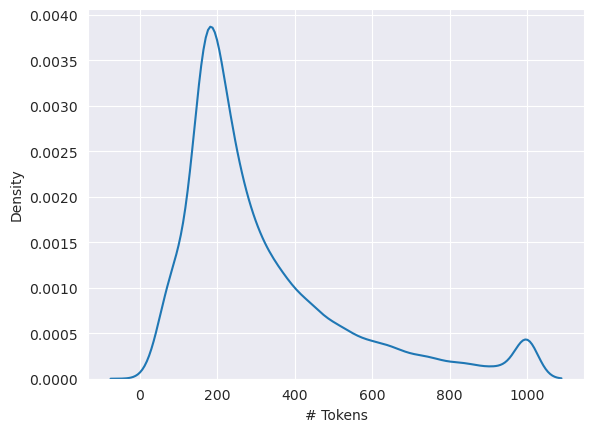

In [10]:
token_counts = []
for _, row in train.iterrows():
    tokens = tokenizer.encode(
        row[ORIGINAL_TEXT],
        max_length=1000,
        truncation=True
    )
    token_counts.append(len(tokens))
sns.kdeplot(token_counts)
plt.xlabel("# Tokens")
plt.ylabel("Density")
plt.show();

Initialize model with pre-trained weights

In [11]:
model = Model(MODEL_NAME)
model.to(device);

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Define hyper-parameters, choose criterion, optimizer

In [12]:
MAX_TOKEN_COUNT = 256
TRAIN_BATCH = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-05
NUM_WORKERS = 0

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
saved_models_path = Path(os.path.join(data.current_path, SAVED_MODELS))
saved_models_path.mkdir(parents=True, exist_ok=True)

Build dataloaders

In [13]:
train_dataset = CustomDataset(
    train,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)
valid_dataset = CustomDataset(
    valid,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=TRAIN_BATCH, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=VALID_BATCH_SIZE, num_workers=NUM_WORKERS)

Train

In [14]:
# Move model to device
model.to(device)
# Lists to keep the losses and evaluation scores at the end of each epoch
train_loss, valid_loss = list(), list()
for epoch in range(EPOCHS):
    # Dummy lists to keep the losses and evaluation scores at the end of each iteration
    # (one batch forward and backward process)
    train_batch_loss, valid_batch_loss = list(), list()
    # Training mode
    model.train()
    for i, item in enumerate(train_loader):
        # Move input to device
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)
        # Forward pass
        out = model(input_ids, attention_mask, token_type_ids)
        # Calculate loss
        loss = criterion(out, target)
        # Reset gradients
        optimizer.zero_grad()
        # Backward pass (backpropogation)
        loss.backward()
        # Update weights
        optimizer.step()
        # Collect loss and evaluation scores
        train_batch_loss.append(loss.item())
        message = \
            f"EPOCH:{epoch+1}/{EPOCHS}, " + \
            f"step:{i+1}/{len(train_loader)}, " + \
            f"loss={loss.item()}"
        print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    train_loss.append(np.array(train_batch_loss).mean())
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        for i, item in enumerate(valid_loader):
            # Move input to device
            input_ids = item["input_ids"].to(device, dtype=torch.long)
            attention_mask = item["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
            target = item["target"].to(device, dtype=torch.float)
            # Forward pass
            out = model(input_ids, attention_mask, token_type_ids)
            # Calculate loss
            loss = criterion(out, target)
            valid_batch_loss.append(loss.item())
            message = \
                f"EPOCH:{epoch+1}/{EPOCHS}, " + \
                f"step:{i+1}/{len(valid_loader)}, " + \
                f"loss={loss.item()}"
            print("\r", message, end="")
    # Take the average of iteration losses and evaluation scores
    # and append it to the epoch losses list
    valid_loss.append(np.array(valid_batch_loss).mean())
    message = \
        f"EPOCH:{epoch+1}/{EPOCHS} - " + \
        f"Training Loss: {train_loss[-1]}, " + \
        f"Validation Loss: {valid_loss[-1]}"
    print("\r", message)
    # Save model
    state = f"epoch_{epoch+1:03}.pth"
    state_dict_path = os.path.join(saved_models_path, state)
    torch.save(model.state_dict(), state_dict_path)

 EPOCH:1/5 - Training Loss: 0.3234626506878571, Validation Loss: 0.22580579149572155
 EPOCH:2/5 - Training Loss: 0.1848209788678849, Validation Loss: 0.2164956399628633
 EPOCH:3/5 - Training Loss: 0.11367987051331015, Validation Loss: 0.30492531364382824
 EPOCH:4/5 - Training Loss: 0.07120071519106701, Validation Loss: 0.3116419012127798
 EPOCH:5/5 - Training Loss: 0.04409565870529067, Validation Loss: 0.30616273986222814


In [15]:
best_epoch = np.argmin(valid_loss) + 1
print(f"Best epoch: {best_epoch}")
state = f"epoch_{best_epoch:03}.pth"
state_dict_path = os.path.join(saved_models_path, state)
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval();


Best epoch: 2


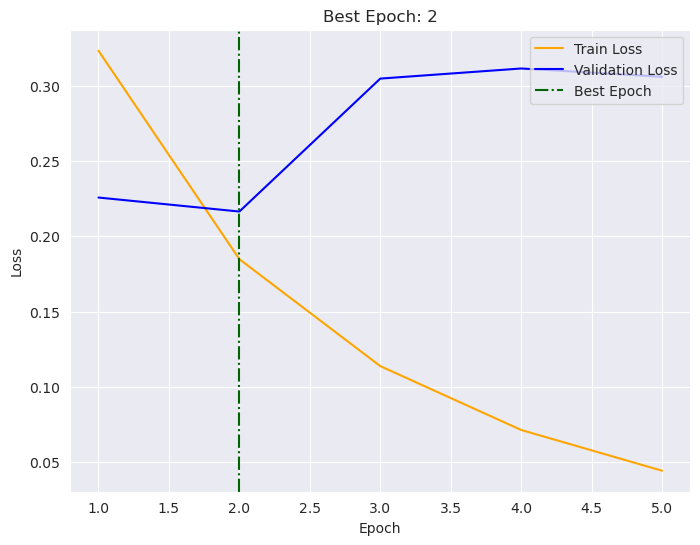

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), train_loss, label="Train Loss", color="orange")
plt.plot(range(1, EPOCHS+1), valid_loss, label="Validation Loss", color="blue")
plt.axvline(x=best_epoch, label="Best Epoch", color="darkgreen", linestyle="dashdot")
plt.xlabel("Epoch")
plt.ylabel(f"Loss")
plt.title(f"Best Epoch: {best_epoch}")
plt.legend(loc="upper right");

Evaluation

In [18]:
eval = CustomEvaluation()

In [24]:
valid_dataset = CustomDataset(
    valid,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)

valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []

with torch.no_grad():
    for i, item in enumerate(valid_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

y_true_val = np.array(y_true).astype(int)
y_pred_probab_val = np.array(y_pred_probab)

Set the threshold which maximizes the accuracy on validation set

In [26]:
threshold = eval.threshold_discovery(y_true=Y_valid.to_numpy(), y_pred_probab=y_pred_probab_val)
print(f"Setting threshold equal to: {threshold}")

Setting threshold equal to: 0.54


Score on validation set

In [27]:
y_pred_val = np.where(y_pred_probab_val > threshold, 1, 0)

eval.evaluate(y_true=y_true_val, y_pred=y_pred_val)

Accuracy     0.918800
Precision    0.926591
Recall       0.909528
F1 Score     0.917980
dtype: float64

Score on test set

In [28]:
test = df_features[df_features[SPLIT].isin([TEST])].copy()
test.reset_index(drop=True, inplace=True)

test_dataset = CustomDataset(
    test,
    MODEL_NAME,
    max_length=MAX_TOKEN_COUNT
)

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
y_pred_probab = []

with torch.no_grad():
    for i, item in enumerate(test_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model(input_ids, attention_mask, token_type_ids)
        out = torch.sigmoid(out)

        y_true.append(target.to("cpu").numpy().reshape(-1,))
        y_pred_probab.append(out.to("cpu").numpy().reshape(-1,))

y_true_test = np.array(y_true).astype(int)
y_pred_probab_test = np.array(y_pred_probab)


In [32]:
y_pred_test = np.where(y_pred_probab_test > threshold, 1, 0)

eval.evaluate(y_true=y_true_test, y_pred=y_pred_test)

Accuracy     0.917520
Precision    0.929689
Recall       0.903360
F1 Score     0.916335
dtype: float64

In [ ]:
pred_df_td = test[[ORIGINAL_TEXT, TARGET]].copy()
y_pred_test_td_inv = [list(y) for y in features.mlb.inverse_transform(y_pred_test_td)]
pred_df_td[PREDICTION] = y_pred_test_td_inv
save_to = os.path.join(data.reports_path, "bert-evaluation-td.pkl")
pred_df.to_pickle(save_to)

In [38]:
pred_df = test[[ORIGINAL_TEXT, TARGET]].copy()
pred_df[PREDICTION] = y_pred_test.reshape(-1,)
save_to = os.path.join(data.reports_path, "bert-prediction.pkl")
pred_df.to_pickle(save_to)